## Preamble: Libs + signal def

In [1]:
import itertools, importlib, sys, warnings, os

from itertools import compress
from misc_expts import heatmap, annotate_heatmap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
import tensorflow as tf
print("Tensorflow version:", tf.__version__)


## suppress annoy verbose tf msgs
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '3' to block all including error msgs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Tensorflow version: 1.15.0


In [2]:
sys.path.append('./embodied_arch')
import embodied_arch.embodied_indep as emi
importlib.reload(emi)

from embodied_misc import ActionPolicyNetwork, ValueNetwork, SensoriumNetworkTemplate

In [3]:
sys.path.append('./minoritygame')
import minoritygame.minority_multienv as MGME
importlib.reload(MGME) 


%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7,7)

log_path = './log/mingame'

## Setup k-vs-(N-k) Mingame Env

In [4]:
importlib.reload(MGME)

# n_agents = 61
# exos = (np.random.sample(n_agents) < 0.3)  # random selection
# exos = [True, True, False, False, False, True]  # Majority subpop
# exos = [True, True, False, False, False, False]  # Minority subpop
# exos = [True, True, True, False, False, False, False, False, False, False]

exos = [True]*10  ## Only RL players
menv = MGME.MinorityGame_Multiagent_env(
    m=3, s=4,
    exo_actorsQ=exos
)

print(len(menv.actor_exoQ), menv.actor_count, menv.actor_index)
print(menv.state_space_size, menv.action_space_size)

10 10 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
3 1


In [5]:
len(menv.actor_exoQ), (len(menv.agents), menv.nagents)

(10, (10, 10))

## Setup MARL

In [6]:
# num_episodes, n_epochs, max_len = (100, 601, 251)
# num_episodes, n_epochs, max_len = (100, 751, 150)
num_episodes, max_len, n_epochs, evry = (100, 100, 601, 150)

In [7]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(32,), gamma_reg=5e-1)
value = lambda s: ValueNetwork(s, hSeq=(16,8,), gamma_reg=1.)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(
    st, hSeq=(16,16,), 
    out_dim=out_dim, gamma_reg=5.
)

In [8]:
tf.reset_default_graph()
importlib.reload(emi)
emi._ent_decay_ = 0.5
print(emi._ent_decay_)

0.5


In [9]:
## REINFORCE with Baseline
# emi.EmbodiedAgent_IRFB(
#     name="mgRFB_k-vs-N-k",
#     env_=menv, latentDim=4, 
#     alpha_p=5.e-1, alpha_v=1e-2, 
#     actorNN=actor, valueNN=value,
#     sensorium=sensor,
#     max_episode_length=max_len
# )

In [10]:
## Actor-Critic
embpopn = emi.EmbodiedAgent_IAC(
    name="mgAC_k-vs-N-k", env_=menv, 
    alpha_p=50., alpha_v=10.,
    actorNN=actor, valueNN=value,
    latentDim=12, sensorium=sensor,
    max_episode_length=max_len, _every_=evry,
    CyclicSchedule=None #("log", 150)  #("exp", 150)
)

print(embpopn, embpopn.s_size, embpopn.a_size)

<embodied_arch.embodied_indep.EmbodiedAgent_IAC object at 0x1c36462dd0> 3 1


In [11]:
sess = tf.InteractiveSession()
embpopn.init_graph(sess)  # note tboard log dir

Tensorboard logs in:  ./log/train_mgAC_k-vs-N-k_1716


In [12]:
## Verify step + play set up
state = embpopn.env.reset()
embpopn.play(sess)
np.sum(np.array(embpopn.episode_buffer['rewards']), axis=0)
# np.array(embpopn.episode_buffer['rewards'])

array([30., 49., 37., 50., 28., 44., 36., 36., 46., 37.])

### Burn-in Minority Game to Equilibrium

[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]
[56.252 59.372 25.    50.    84.372 12.5   62.5   34.372 40.624 62.504] 48.753 48.74800000000001


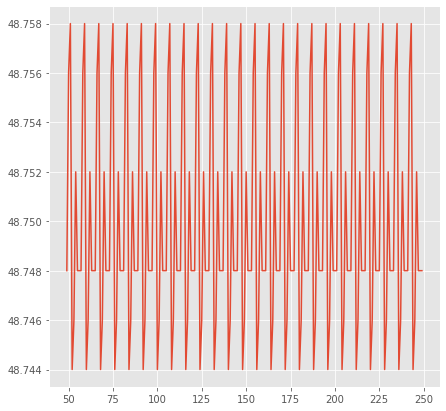

In [13]:
burn_in = 250  # n_epochs
print(embpopn.env.reset())

mg_hist = np.zeros([burn_in, sum(exos)])
for k in range(burn_in):
    tmp = np.zeros(sum(exos))
    for _ in range(embpopn.max_episode_length): 
        _, popn_acts, _ = embpopn.env.stepAll()
        tmp += 100.*np.array(
            list(compress(popn_acts, exos)), dtype=float)/float(embpopn.max_episode_length)
    mg_hist[k,:] = tmp

# rwd_hist = 100.*mg_hist/float(embpopn.max_episode_length)
rwd_hist = mg_hist
plt.plot(pd.Series(np.mean(mg_hist, axis=1)).rolling(window=50).mean().values);

print(
    np.mean(mg_hist, axis=0),
    np.mean(np.mean(mg_hist, axis=1)[:embpopn.max_episode_length]),
    np.mean(np.mean(mg_hist, axis=1)[-embpopn.max_episode_length:])
)
# no equilibrium, just cycling

### Baseline for Agents

In [14]:
print('Baselining untrained pnet...')
rwd_mg0 = []
acts_cov = np.zeros([embpopn.actor_count,embpopn.actor_count])
for k in range(num_episodes):
    embpopn.play(sess, terminal_reward=0.)
    rwd_mg0.append(embpopn.last_total_returns)
    actions = np.array(embpopn.episode_buffer['actions']).T
    acts_cov = acts_cov + (np.cov(actions)/num_episodes)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

# Compute avg rewards
base_perf_mg = 100.*np.mean(np.array(rwd_mg0)/float(embpopn.max_episode_length))
base_per_agent = 100.*np.mean(np.array(rwd_mg0)/float(embpopn.max_episode_length), axis=0)

print("\n\nAgents win an average of {} pct".format(base_perf_mg))
print("Per Agent Win Pcts: {} pct".format(base_per_agent))

Baselining untrained pnet...
Episode 99/100

Agents win an average of 39.43 pct
Per Agent Win Pcts: [23.57 42.74 40.67 43.08 37.95 39.71 42.77 43.22 40.99 39.6 ] pct


## Train MARL Agents

	Iteration 0: Value loss([0.12700501 0.11550127 0.28819647 0.14898224 0.11421435 0.4566232
	Iteration 1: Value loss([0.10378116 0.2190391  0.9417637  0.16653095 0.5328182  2.12643218
	Iteration 2: Value loss([ 0.08827469  1.15620577  2.96635151  0.79642957  3.8017931   8.70529747
	Iteration 3: Value loss([ 0.10162896  6.11046886  3.73781157  3.45893455 14.17504597 21.01685143
	Iteration 4: Value loss([ 0.11251415 18.11382484  5.46812201 11.10969734 33.18328094  3.53509331
	Iteration 5: Value loss([ 0.13545193 51.2919426  10.4015646  14.16673946  7.08055496  3.27228999
	Iteration 6: Value loss([ 0.28660968  7.73201895 35.3749733   4.02393723 12.00334263  2.25437164
	Iteration 7: Value loss([ 0.793275   22.30257034 60.71638107  9.25105572  3.75563717  1.42454386
	Iteration 8: Value loss([ 2.30907011 23.80008507 10.36550522  7.50718737  2.56240964  1.35025179
	Iteration 9: Value loss([ 6.15763044  7.73803949 23.73461342  3.95504236 10.8403511   2.01471853
	Iteration 10: Value loss([10.949

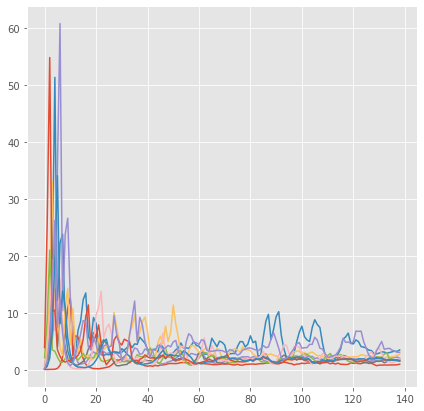

In [15]:
obs = []
for ct in range(140):
    embpopn.play(sess)
    tmp = embpopn.pretrainCritics(sess)
    obs.append(tmp)
    print('\r\tIteration {}: Value loss({})'.format(ct, tmp), end="")
plt.plot(obs[1:]);

In [16]:
# ### Train Agent w/ Algo on Experience Tuples
# Train pnet on mingame episodes
print('Training...')
saver = tf.train.Saver(max_to_keep=1)
hist = embpopn.work(sess, num_epochs=n_epochs, saver=saver)

Training...
Starting agent mgAC_k-vs-N-k_1716
Epoch no.: 0/601

	Stats @Step 0: 	(Min, Mean, Max)
Perf/Recent Rewards: (29.0, 38.4, 54.0)
Losses/Policy LLs: (-2.1116219, -0.56710964, -0.12901758)
Losses/Critic Scores: (13.707776, 19.295362, 25.804739)
Losses/Policy Entropies: (0.36899495, 0.56565344, 0.6715431)
Saved Model
Epoch no.: 150/601

	Stats @Step 150: 	(Min, Mean, Max)
Perf/Recent Rewards: (23.0, 39.2, 49.0)
Losses/Policy LLs: (-0.8579946, -0.68778384, -0.55166763)
Losses/Critic Scores: (13.152962, 19.402176, 22.062965)
Losses/Policy Entropies: (0.68155384, 0.6882328, 0.6928753)
Saved Model
Epoch no.: 300/601

	Stats @Step 300: 	(Min, Mean, Max)
Perf/Recent Rewards: (23.0, 39.4, 53.0)
Losses/Policy LLs: (-0.9388951, -0.6868563, -0.49603498)
Losses/Critic Scores: (12.648324, 18.790354, 22.014023)
Losses/Policy Entropies: (0.66921973, 0.6830475, 0.692693)
Saved Model
Epoch no.: 450/601

	Stats @Step 450: 	(Min, Mean, Max)
Perf/Recent Rewards: (23.0, 37.3, 45.0)
Losses/Policy LLs

### Post-test Agent

In [17]:
# Test pnet!
print('Testing...')
rwd_mg = []
acts_cov = np.zeros([embpopn.actor_count,embpopn.actor_count])
for k in range(num_episodes):
    embpopn.play(sess, terminal_reward=0.)
    rwd_mg.append(embpopn.last_total_returns)
    actions = np.array(embpopn.episode_buffer['actions']).T
    acts_cov = acts_cov + (np.cov(actions)/num_episodes)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

# Compute avg rewards
trained_perf_mg = 100.*np.mean(np.array(rwd_mg)/float(embpopn.max_episode_length))
trained_per_agent = 100.*np.mean(np.array(rwd_mg)/float(embpopn.max_episode_length), axis=0)

Testing...
Episode 99/100

In [18]:
print("\nAgent wins an average of {:0.3f} pct compared to baseline of {:0.3f} pct".format(
    trained_perf_mg, base_perf_mg) )

print("\nBaseline Per Agent Win Pct: {} pct".format(base_per_agent))
print("Trained Per Agent Win Pct: {} pct".format(trained_per_agent))


Agent wins an average of 37.877 pct compared to baseline of 39.430 pct

Baseline Per Agent Win Pct: [23.57 42.74 40.67 43.08 37.95 39.71 42.77 43.22 40.99 39.6 ] pct
Trained Per Agent Win Pct: [26.15 39.78 38.87 39.84 39.02 39.25 38.85 38.81 38.82 39.38] pct


In [19]:
plt.rcParams['figure.figsize'] = (6,5)
acts_corr = acts_cov.copy()
jm, km = acts_corr.shape
for j in range(jm):
    for k in range(km):
        denom = np.sqrt((acts_corr[j,j])*(acts_corr[k,k]))
        acts_corr[j,k] = acts_corr[j,k]/denom

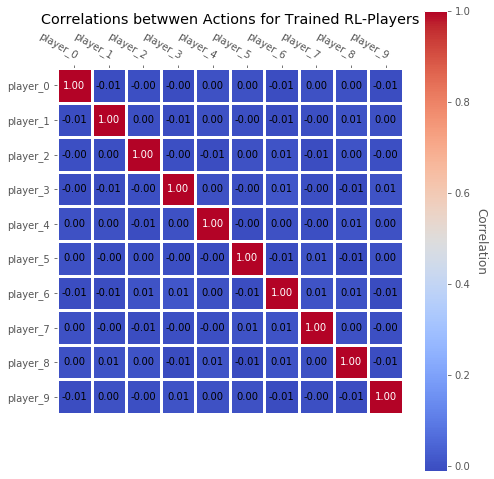

In [20]:
plt.rcParams['figure.figsize'] = (7, 7)
fig, ax = plt.subplots()
ax.grid(False)
ax.set_title("Correlations betwwen Actions for Trained RL-Players")
im, cbar = heatmap(data=(acts_corr), 
                   row_labels=embpopn.actor_names, col_labels=embpopn.actor_names, 
                   ax=ax, cmap="coolwarm", cbarlabel="Correlation") #cmap="coolwarm" RdYlGn
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

In [21]:
rwds0_df = pd.DataFrame(100.*(np.array(rwd_mg0)/float(embpopn.max_episode_length)))
rwds_df = pd.DataFrame(100.*(np.array(rwd_mg)/float(embpopn.max_episode_length)))

rwds0_df['Wave'] = "Baseline"
rwds_df['Wave'] = "Trained"

resDF = pd.concat([rwds0_df, rwds_df])
resDF.columns = ["Agent"+str(tc) if tc is not "Wave" else tc for tc in resDF.columns]
# resDF['id'] = resDF.index
# print(resDF.shape)
# resDF.head()

resDF = resDF.melt(
    id_vars=['Wave'], #['id', 'Wave'],
    value_vars=[tc for tc in resDF.columns if "Agent" in tc]
)
resDF = resDF.rename(columns={"variable": "Agent", "value": "Win_pct"})
# print(resDF.shape)
res_tabs = resDF.groupby(['Agent','Wave']).aggregate(['mean','std']) # res_tabs
# resDF.head()

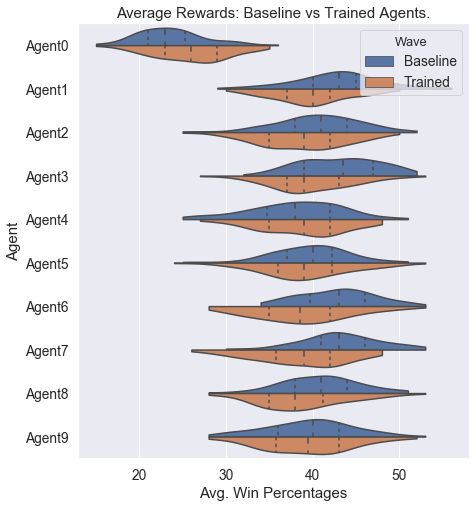

In [22]:
plt.rcParams['figure.figsize'] = (7, 8)
sns.set(font_scale=1.25)

fig = sns.violinplot(data=resDF, x="Win_pct", y="Agent",
                     cut=0, hue="Wave",
                     split=True, scale="count", inner="quartile");
fig.set_title(
    'Average Rewards: Baseline vs Trained Agents.');
fig.set_xlabel('Avg. Win Percentages');
# fig.legend(loc='upper left');

In [23]:
base_meanDF = resDF[resDF.Wave=="Baseline"].groupby(['Agent']).aggregate(['mean'])
base_meanDF.sort_index(inplace=True)

trained_meanDF = resDF[resDF.Wave=="Trained"].groupby(['Agent']).aggregate(['mean'])
trained_meanDF.sort_index(inplace=True)

mean_diffDF = (trained_meanDF - base_meanDF)
mean_diffDF.columns = ['Mean_Win_pct_Change']
# mean_diffDF.head()

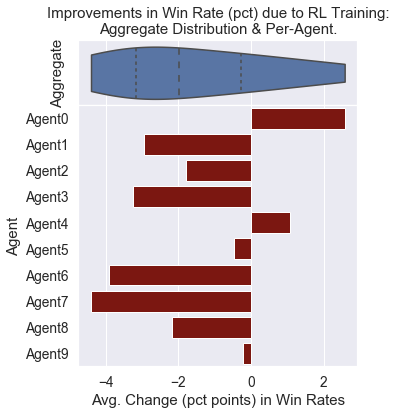

In [24]:
plt.rcParams['figure.figsize'] = (5, 6)
sns.set_color_codes("dark")
fig, axs = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [1,4]})
cmp = sns.violinplot(x='Mean_Win_pct_Change', cut=0, inner='quartile',data=mean_diffDF, ax=axs[0])
# cmp = sns.boxplot(x='Mean_Win_pct_Change',data=mean_diffDF, ax=axs[0])
axs[0].set_ylabel('Aggregate');
axs[0].set_title(
    'Improvements in Win Rate (pct) due to RL Training:\nAggregate Distribution & Per-Agent.'
);

sns.barplot(y=mean_diffDF.index, x="Mean_Win_pct_Change", 
            data=mean_diffDF, color="r",
            label="Success Rate", ax=axs[1]);
plt.subplots_adjust(wspace=0, hspace=0)
axs[1].set_xlabel('Avg. Change (pct points) in Win Rates');

### Baseline for Default Behavioral Model

In [25]:
mg_hist = np.zeros([num_episodes, sum(exos)])
for k in range(num_episodes):
    tmp = np.zeros(sum(exos))
    for _ in range(embpopn.max_episode_length):
        _, popn_acts, _ = embpopn.env.stepAll()
        tmp += 100.*np.array(
            list(compress(popn_acts, exos)), dtype=float)/float(embpopn.max_episode_length)
    mg_hist[k,:] = tmp

np.mean(mg_hist, axis=0)

array([56.21, 59.26, 24.99, 50.04, 84.37, 12.46, 62.51, 34.47, 40.6 ,
       62.53])

In [26]:
rwds_dbm = mg_hist # 100.*mg_hist/float(embpopn.max_episode_length)

print(np.mean(rwds_dbm), "\n",
      np.mean(rwds_dbm, axis=0)
     )

48.744 
 [56.21 59.26 24.99 50.04 84.37 12.46 62.51 34.47 40.6  62.53]


### Compare to Default Behavioral Model

[-30.06 -19.48  13.88 -10.2  -45.35  26.79 -23.66   4.34  -1.78 -23.15]


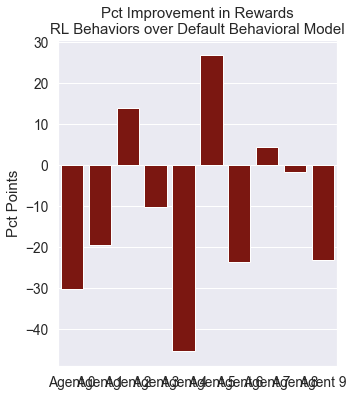

In [27]:
trcmp = 100.*(np.array(rwd_mg)/float(embpopn.max_episode_length))
cmp = np.mean((trcmp-rwds_dbm), axis=0)
print(cmp)
bplot = sns.barplot(x=["Agent "+str(j) for j in range(sum(exos))], y=cmp, color="r");
bplot.set_ylabel('Pct Points');
bplot.set_title(
    'Pct Improvement in Rewards\nRL Behaviors over Default Behavioral Model');

In [28]:
plt.rcParams['figure.figsize'] = (8,3)
np.mean(trcmp - np.mean(rwds_dbm, axis=0))

-10.867